The primary objective of this competition is to employ deep learning-based regression models, such as Convolutional Neural Networks (CNNs) like ConvNext or Transformers, to predict plant traits from photographs. These plant traits, although available for each image, may not yield exceptionally high accuracies due to the inherent heterogeneity of citizen science data. The various plant traits describe chemical tissue properties that are loosely related to the visible appearance of plants in images. Despite the anticipated moderate accuracies, the overarching goal is to explore the potential of this approach and gain insights into global changes affecting ecosystems. Your contribution to uncovering the wealth of data and the distribution of plant traits worldwide is invaluable.

Our goal is to predict a broad set of 6 plant traits (e.g. leaf area, plant height) from crowd-sourced plant images and some ancillary data. 

The models will be evaluated against the independent test data. The evaluation metric for this competition is the mean R2 over all 6 traits. The R2 is commonly used for evaluating regression models and is the ratio of the sum of squares the residuals (SSres) to the total sum of squares (SStot).

The R2 can result in large negative values. To prevent that we will only consider R2 values > 0.

The submission should include a .csv file with a prediction for each trait and the following columns: id (see labels) and a prediction for each trait (X1080, X50, …). An example is given with sample_submission.csv


In [2]:
#imports and variables
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_DIR = os.getcwd() +'/data/' #data directory kaggle: /kaggle/input/planttraits2024/

In [3]:
class CONFIG:
    sub = f"{DATA_DIR}sample_submission.csv"
    trgts = f"{DATA_DIR}target_name_meta.tsv"
    train_path = f"{DATA_DIR}train.csv"
    test_path = f"{DATA_DIR}test.csv"
    train_image_path = f"{DATA_DIR}train_images/"
    test_image_path = f"{DATA_DIR}test_images/"
    SEED = 42 #seed for reproducibility
    IMAGE_SIZE = [224, 224] 
    BATCH_SIZE = 128
    EPOCHS = 8
    CLASS_NAMES  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'] #target columns in dataset to predict

    aux_class_names = list(map(lambda x: x.replace("mean","sd"), CLASS_NAMES))
    num_classes = len(CLASS_NAMES)
    aux_num_classes = len(aux_class_names)

config = CONFIG()
len(CONFIG.CLASS_NAMES)

6

In [4]:
#load train.csv and test.csv as pandas dataframe
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)

In [5]:
#check the shape of the train data
print(train.shape)
train.head()

(55489, 176)


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


In [6]:
#check the shape of the test data
print(test.shape)
test.head()

(6545, 164)


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.385838,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.279171,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672
2,202604412,8.105556,378.328583,39.928570,41.885647,722.071167,34.853809,133,134,139,...,0.392073,0.418509,0.437172,0.453239,0.445230,0.435441,0.432758,0.429839,0.417250,0.394216
3,201353439,7.077679,878.785706,70.428574,37.045235,669.389343,25.150000,103,140,116,...,0.384626,0.313667,0.352311,0.401131,0.513455,0.519174,0.474007,0.469071,0.408466,0.366724
4,195351745,4.790555,2299.366699,150.199997,24.136568,462.887695,22.516666,85,114,98,...,0.515619,0.506952,0.462181,0.397052,0.358262,0.369279,0.414420,0.469002,0.519534,0.521837


In [11]:
#read target_name_meta.tsv
target_name_meta = pd.read_csv(DATA_DIR + '/target_name_meta.tsv', sep='\t')
print(target_name_meta)

#compare column names of train and test data, and find the difference
train_col = train.columns
test_col = test.columns
# print('train_col:', train_col)
# print('test_col:', test_col)
print('train_col - test_col:', list(set(train_col) - set(test_col)))

  trait_ID                                        trait_name 
0       X4  Stem specific density (SSD) or wood density (s...
1      X11  Leaf area per leaf dry mass (specific leaf are...
2      X18                                      Plant height 
3      X26                                     Seed dry mass 
4      X50           Leaf nitrogen (N) content per leaf area 
5    X3112  Leaf area (in case of compound leaves: leaf, u...
train_col - test_col: ['X18_sd', 'X18_mean', 'X26_sd', 'X3112_sd', 'X4_mean', 'X11_mean', 'X50_sd', 'X26_mean', 'X4_sd', 'X11_sd', 'X3112_mean', 'X50_mean']


the train dataset consists of 176 data parameters and 55489 images with tabulated data,
the test dataset consists of 164 data parameters and 13873 images with tabulated data.

the discrepancy between the train and test dataset comes from the following 12 parameters missing from the test dataset:

['X11_sd', 'X26_sd', 'X26_mean', 'X50_sd', 'X50_mean', 'X3112_sd', 'X4_mean', 'X18_mean', 'X18_sd', 'X11_mean', 'X3112_mean', 'X4_sd']

these parameters are missing because they are meant to be estimated using the model

In [54]:
#add image path to the dataframe
train['image_path'] = f'{DATA_DIR}/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = f'{DATA_DIR}/test_images/' + test['id'].astype(str) + '.jpeg'

# drop missing values in the target columns
train = train.drop_duplicates(subset=['id']).dropna(subset=CONFIG.CLASS_NAMES)
display(train.head(2))

FEATURE_COLS = test.columns[1:-1].tolist()
display(train.shape, test.shape, FEATURE_COLS)


,id,image_path,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,192027691,/home/btg/Documents/GitHub-khlee/CS5242_plantT...,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,195542235,/home/btg/Documents/GitHub-khlee/CS5242_plantT...,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472


(55489, 8)

(6545, 165)

['WORLDCLIM_BIO1_annual_mean_temperature',
 'WORLDCLIM_BIO12_annual_precipitation',
 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
 'WORLDCLIM_BIO15_precipitation_seasonality',
 'WORLDCLIM_BIO4_temperature_seasonality',
 'WORLDCLIM_BIO7_temperature_annual_range',
 'SOIL_bdod_0.5cm_mean_0.01_deg',
 'SOIL_bdod_100.200cm_mean_0.01_deg',
 'SOIL_bdod_15.30cm_mean_0.01_deg',
 'SOIL_bdod_30.60cm_mean_0.01_deg',
 'SOIL_bdod_5.15cm_mean_0.01_deg',
 'SOIL_bdod_60.100cm_mean_0.01_deg',
 'SOIL_cec_0.5cm_mean_0.01_deg',
 'SOIL_cec_100.200cm_mean_0.01_deg',
 'SOIL_cec_15.30cm_mean_0.01_deg',
 'SOIL_cec_30.60cm_mean_0.01_deg',
 'SOIL_cec_5.15cm_mean_0.01_deg',
 'SOIL_cec_60.100cm_mean_0.01_deg',
 'SOIL_cfvo_0.5cm_mean_0.01_deg',
 'SOIL_cfvo_100.200cm_mean_0.01_deg',
 'SOIL_cfvo_15.30cm_mean_0.01_deg',
 'SOIL_cfvo_30.60cm_mean_0.01_deg',
 'SOIL_cfvo_5.15cm_mean_0.01_deg',
 'SOIL_cfvo_60.100cm_mean_0.01_deg',
 'SOIL_clay_0.5cm_mean_0.01_deg',
 'SOIL_clay_100.200cm_mean_0.01_d

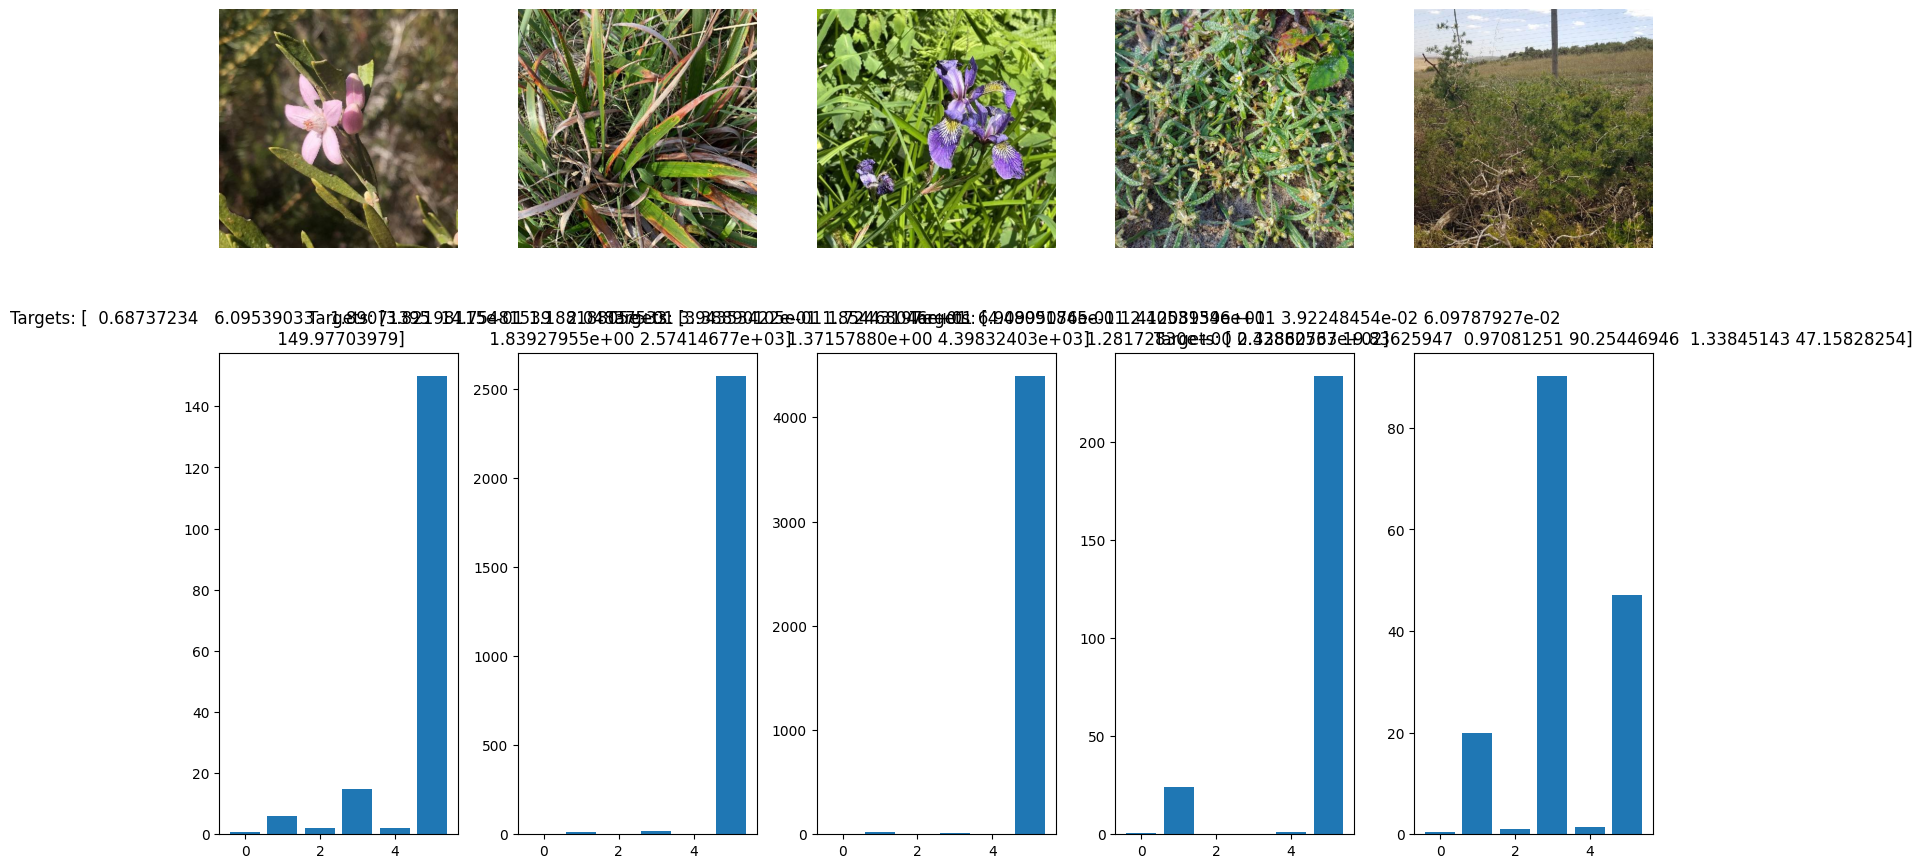

In [9]:
image_path = 'data/train_images'

image_files = [f for f in os.listdir(image_path) if f.endswith('.jpeg')]

random_images = random.sample(image_files, 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 10))

for i, image_file in enumerate(random_images):
    img_path = os.path.join(image_path, image_file)
    img = mpimg.imread(img_path)
    
    # Extract the corresponding target values from the DataFrame
    image_id = image_file.split('.')[0]
    target_values = train.loc[train['id'] == int(image_id), config.CLASS_NAMES].values.flatten()
    # Plot the image
    axes[0, i].imshow(img)
    axes[0, i].axis('off')

    # Plot the target values
    axes[1, i].bar(range(len(target_values)), target_values)
    axes[1, i].set_title(f'Targets: {target_values}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

/tmp/ipykernel_33060/90817092.py:6: RuntimeWarning: invalid value encountered in log1p
  log_vals = np.log1p(train[col].values)


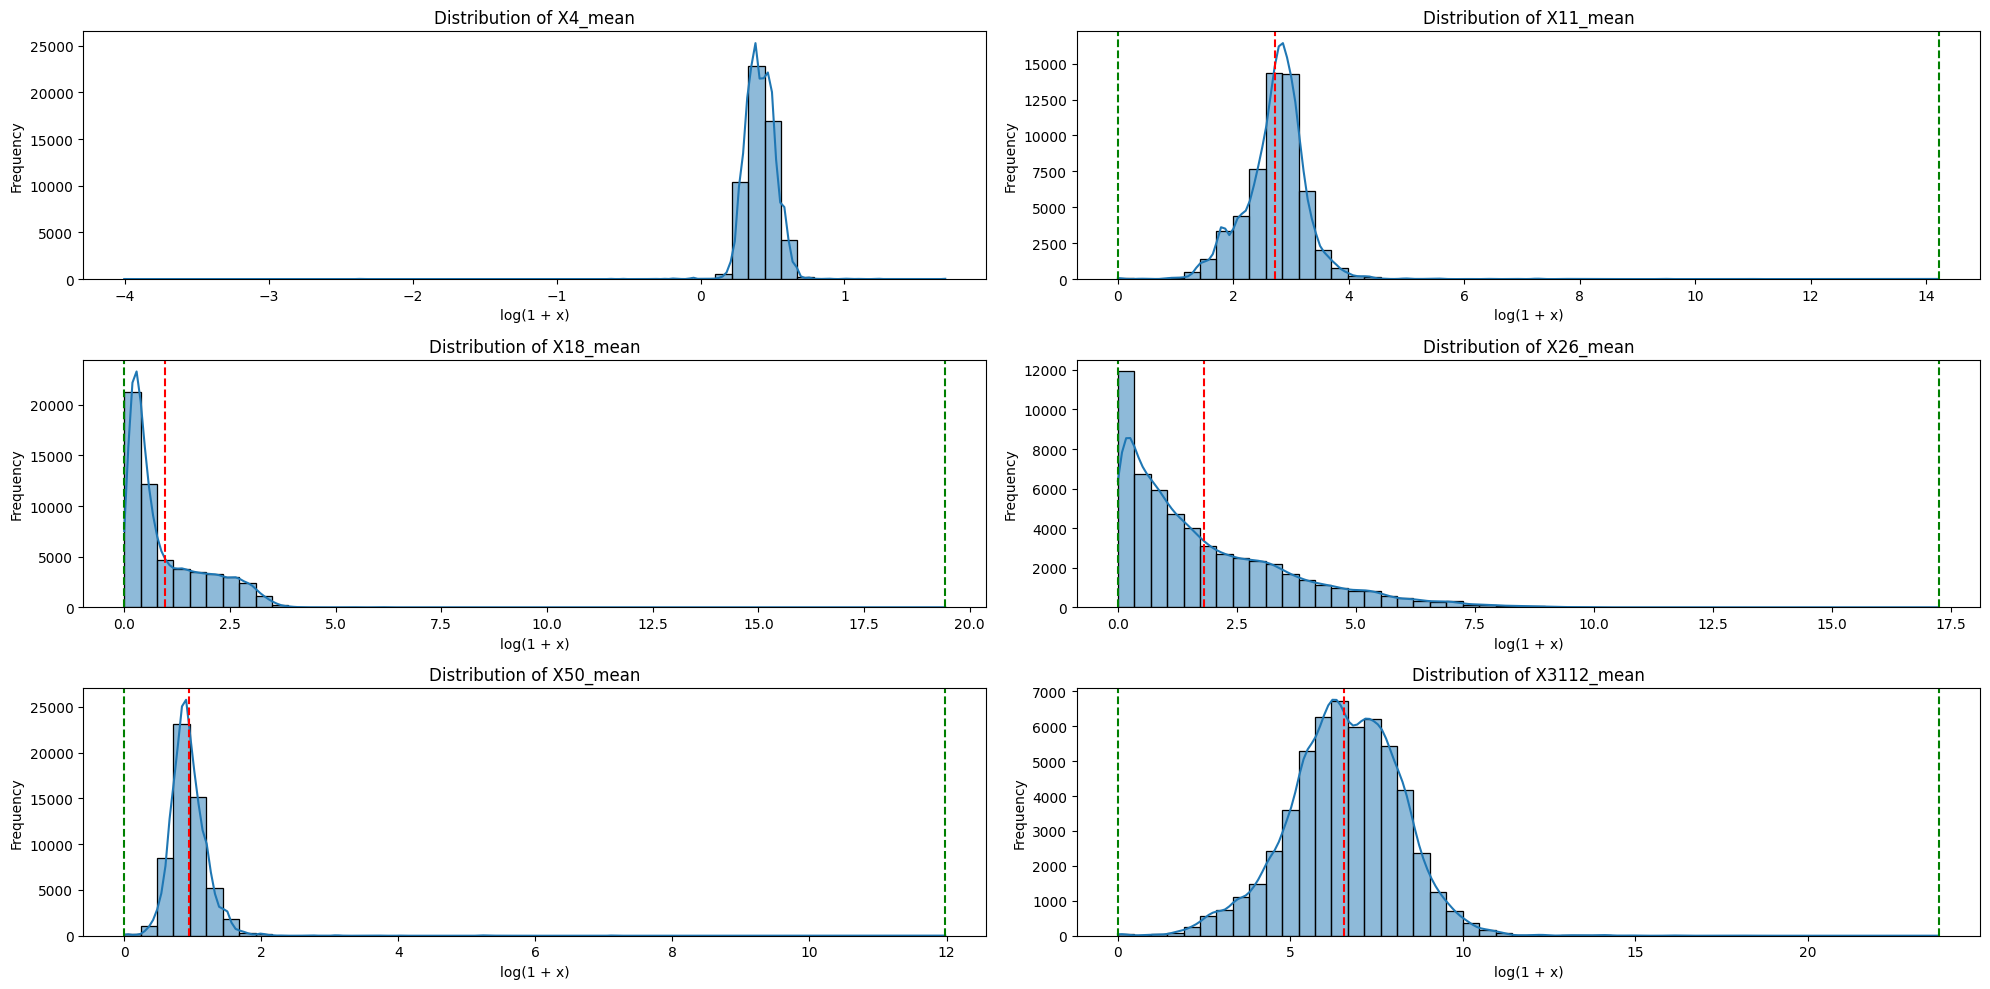

In [10]:
#plot the distribution of the target columns
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(config.CLASS_NAMES):
    log_vals = np.log1p(train[col].values)
    sns.histplot(log_vals, kde=True, ax=axes[i], bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('log(1 + x)')
    axes[i].set_ylabel('Frequency')
    #add mean, min and max values to the plot
    mean = log_vals.mean()
    min_val = log_vals.min()
    max_val = log_vals.max()
    axes[i].axvline(mean, color='r', linestyle='--')
    axes[i].axvline(min_val, color='g', linestyle='--')
    axes[i].axvline(max_val, color='g', linestyle='--')

plt.tight_layout()
plt.show()
